Loading the data directly through Kaggle's API

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install -U -q kaggle==1.5.8

     |████████████████████████████████| 59 kB 4.9 MB/s 


In [3]:
%cd /content/gdrive/MyDrive/MLP/

/content/gdrive/MyDrive/MLP


In [4]:
import os

In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/MLP/"
! kaggle competitions download -c plant-pathology-2021-fgvc8

100% 14.9G/14.9G [05:29<00:00, 70.8MB/s]
100% 14.9G/14.9G [05:32<00:00, 48.0MB/s]


In [6]:
! unzip -q plant-pathology-2021-fgvc8.zip -d train

Data processing


In [7]:
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

%cd /content/gdrive/MyDrive/MLP/train/

/content/gdrive/MyDrive/MLP/train


In [8]:
df = pd.read_csv('train.csv')
#print(df.head())

# df_test = pd.read_csv('sample_submission.csv')
# print(df_test.head())

In [9]:
new_labels = df['labels'].to_list()

for i in range(len(new_labels)):
  if new_labels[i] == 'scab frog_eye_leaf_spot complex' or new_labels[i] == 'scab frog_eye_leaf_spot':
    new_labels[i] = 'scab'
  elif new_labels[i] == 'frog_eye_leaf_spot complex':
    new_labels[i] = 'frog_eye_leaf_spot'
  elif new_labels[i] == 'powdery_mildew complex':
    new_labels[i] = 'powdery_mildew'
  elif new_labels[i] == 'rust complex' or new_labels[i] == 'rust frog_eye_leaf_spot':
    new_labels[i] = 'rust'


In [10]:
df['adjusted labels'] = np.array(new_labels)
df = df.drop('labels', axis = 1)

#print(df)

In [11]:
def sample(df, sample_size):
  """
  This function gets an equal sample inclusive of all classes from the input dataframe
  """
  df_sampled = []
  classes = df['adjusted labels'].unique()

  for i in classes:
      g = df[df['adjusted labels'] == i].sample(sample_size)
      df_sampled.append(g)

  df_sampled = pd.concat(df_sampled)
  return df_sampled

df_sampled = sample(df, 1184)
print(df_sampled)

                      image adjusted labels
16939  f5ec9eb058923293.jpg         healthy
16649  f4d4e9d1a1a0b536.jpg         healthy
4424   a3ecc1d5de9a5848.jpg         healthy
4893   a5dec1984966f331.jpg         healthy
8813   bee099878e1c6674.jpg         healthy
...                     ...             ...
12548  d7649b9ce0c06739.jpg  powdery_mildew
11186  ce4874c8e7aaaf42.jpg  powdery_mildew
13078  dbc06443d7c966b2.jpg  powdery_mildew
13198  dcce49e42723e09b.jpg  powdery_mildew
1642   8cec462ef8f07b28.jpg  powdery_mildew

[7104 rows x 2 columns]


In [12]:
def one_hot(df):
  """
  This function returns all classes and combination of classes found in the input-dataframe, and returns
  the one-hot encoded version
  """
  one_hot = pd.get_dummies(df['adjusted labels'])
  df = df.drop('adjusted labels', axis = 1)
  df = df.join(one_hot)
  return df

df_onehot = one_hot(df_sampled)
#print(df_onehot)

# df_test = one_hot(df_test)
# print(df_test.head())

In [13]:
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, preprocessing

def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'accuracy']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

In [14]:
# convert dictionary into a hashable type
df_dict = df_onehot.set_index('image').T.to_dict('list')

# gather names of all images in the image-directory
train_images = os.listdir('train_images/')

# # empty column for the actual images
# df_onehot["image_pixels"] = 0

images = []
# find corresponding key to image from directory, and add that image to a list
for image in df_dict.keys():
  if image in train_images:
    img = cv2.imread('train_images/' + image)
    img = cv2.resize(img, (96, 96)) 
    images.append(img)

labels = list(df_dict.values())

In [15]:
images = np.array(images)
labels = np.array(labels)

In [16]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size = 0.3, random_state=42)

Epoch 1/20
156/156 [==============================] - 73s 30ms/step - loss: 7.0342 - accuracy: 0.3413 - val_loss: 12.3243 - val_accuracy: 0.2702
Epoch 2/20
156/156 [==============================] - 4s 26ms/step - loss: 3.0217 - accuracy: 0.4222 - val_loss: 8.0746 - val_accuracy: 0.2017
Epoch 3/20
156/156 [==============================] - 4s 26ms/step - loss: 1.5122 - accuracy: 0.4813 - val_loss: 5.3038 - val_accuracy: 0.1881
Epoch 4/20
156/156 [==============================] - 4s 25ms/step - loss: 1.2045 - accuracy: 0.5553 - val_loss: 4.3409 - val_accuracy: 0.2008
Epoch 5/20
156/156 [==============================] - 4s 25ms/step - loss: 1.1069 - accuracy: 0.5917 - val_loss: 3.4054 - val_accuracy: 0.3236
Epoch 6/20
156/156 [==============================] - 4s 26ms/step - loss: 1.0135 - accuracy: 0.6219 - val_loss: 3.0375 - val_accuracy: 0.2505
Epoch 7/20
156/156 [==============================] - 4s 25ms/step - loss: 0.9220 - accuracy: 0.6615 - val_loss: 2.3379 - val_accuracy: 0.34

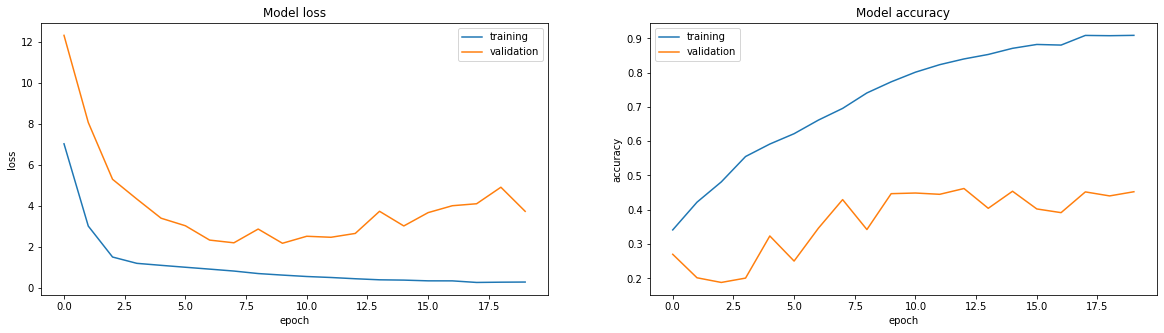

67/67 [==============================] - 1s 13ms/step - loss: 3.7411 - accuracy: 0.4526
Validation Accuracy: 0.45262664556503296


In [17]:

# Define Sequential model
model = models.Sequential()

# create convolutional layer and max pooling layer

model.add(layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# create convolutional layer (larger) and max pooling layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization())

# flatten layers
model.add(layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.5)))

# apply softmax activation for final layer classification
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Dense(6, activation='softmax'))

# normalize input data: set preprocesing dictionary
preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# run training and evaluation function
train_and_evaluate(model, x_train, y_train, x_val, y_val, preprocess)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 64)       2

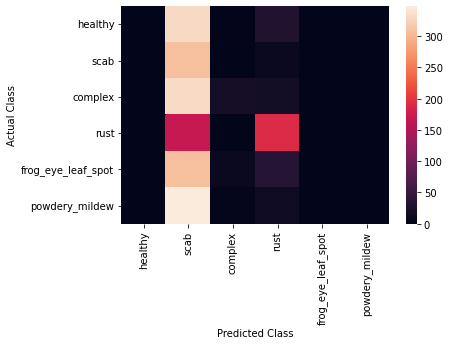

tf.Tensor(
[[  0 331   2  30   0   0]
 [  0 308   0  10   0   0]
 [  0 333  20  17   0   0]
 [  0 171   0 192   0   0]
 [  0 308  10  35   0   0]
 [  0 348   4  13   0   0]], shape=(6, 6), dtype=int32)


In [22]:
import seaborn as sns
import tensorflow as tf
from tensorflow import math as tfmath

classes = df['adjusted labels'].unique()
#x_test_flat = x_train.reshape(x_val.shape[0], (96, 96, 3))

y_true = tf.argmax(y_val, axis=1)
y_pred = tf.argmax(model(x_val), axis=1)

conf_matrix = tfmath.confusion_matrix(y_true, y_pred, num_classes=6)

ax = sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes)
ax.set(xlabel='Predicted Class', ylabel='Actual Class')
plt.show()

print(conf_matrix)

In [20]:
# count occurence of specific labels:
df = df_dict.labels.value_counts()

AttributeError: ignored